#**Taxi Fare**

---

O objetivo dessa análise é : 
Encontrar o valor da corrida de taxi  

# Importação dos Dados

---



1- Instalar o kaggle para utilizar a api :

In [2]:
!pip install kaggle

Agora é preciso passar as credenciais que estão no arquivo Kaggle.json :

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lyon14br","key":"39b015f85c81c7841829b1adc868ea0b"}'}

É preciso mover o arquivo para o .kaggle :

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json

Para tirar os warning é preciso dar permissão :

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

Agora basta importar os arquivos do kaggle, para isso é necessário copiar o link no campo 
api da competição : 

In [6]:
!kaggle competitions download -c new-york-city-taxi-fare-prediction

  0% 0.00/335k [00:00<?, ?B/s]
100% 335k/335k [00:00<00:00, 49.7MB/s]
  0% 0.00/960k [00:00<?, ?B/s]
100% 960k/960k [00:00<00:00, 62.2MB/s]
 99% 1.55G/1.56G [00:19<00:00, 93.8MB/s]
100% 1.56G/1.56G [00:19<00:00, 85.1MB/s]
  0% 0.00/486 [00:00<?, ?B/s]
100% 486/486 [00:00<00:00, 344kB/s]


Para ter certeza se todos os passos anteriores funcionaram, utilize ''!ls' para mostrar a pasta com os arquivo : 

In [7]:
!ls

chatbot.txt		      kaggle.json  sample_submission.csv  train.csv.zip
GCP-Coupons-Instructions.rtf  sample_data  test.csv


Como o arquivo train.csv.zip está ziapdo é preciso descompactar o mesmo :

In [8]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


# Explorando os dados

---



Bibliotecas a serem utilizadas : 

In [0]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

Como o dataset é extremamente grande é preciso diminuir o tamanho a ser passado para o data frame, por isso que p chucksize possue apenas 5 milhões de dados : 

In [0]:
chucksize = 5*10**6
train = pd.read_csv('train.csv', nrows =  chucksize)


Aqui é possível ver como é o formato dos Dados : 

In [11]:
print("shape pf train data ",train.shape)
train.head()

shape pf train data  (5000000, 8)


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


Em seguida os tipos de cada coluna do dataset

In [12]:
train.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

O describe mostra as principais estátisticas do dataset, onde é possivel ter uma ídeia melhor sobre o que está acontecendo com os dados.

In [13]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.000000e+06,5.000000e+06,5.000000e+06,4.999964e+06,4.999964e+06,5.000000e+06
mean,1.134080e+01,-7.250678e+01,3.991974e+01,-7.250652e+01,3.991725e+01,1.684695e+00
std,9.820175e+00,1.280970e+01,8.963509e+00,1.284777e+01,9.486767e+00,1.331854e+00
min,-1.000000e+02,-3.426609e+03,-3.488080e+03,-3.412653e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399206e+01,4.073491e+01,-7.399139e+01,4.073404e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075315e+01,1.000000e+00
75%,1.250000e+01,-7.396711e+01,4.076712e+01,-7.396367e+01,4.076811e+01,2.000000e+00
max,1.273310e+03,3.439426e+03,3.310364e+03,3.457622e+03,3.345917e+03,2.080000e+02


Os Estados unidos possuem um limite de pessoas a serem levados em um táxi. Por isso é necessário remover todos os dados que não atende a esses parametro. 
Como o numero maximo de passageiro utrapassa 200 passageiros é notável que isso se trata de lixo, que deve ser removido. 

In [14]:
print('Tamanho antigo %d' % len(train))
train = train[(train['passenger_count']<=7)]
print('Novo tamanho %d depois de limitar os passageiros a 7' % len(train))


Tamanho antigo 5000000
Novo tamanho 4999989 depois de limitar os passageiros a 7


Quando não tem passageiro no táxi também deve ser considerado um lixo, já que não faz sentido cobrar um corrida para ninguem. 

In [15]:
print('Tamanho antigo %d' % len(train))
train = train[(train['passenger_count']>0)]
print('Novo tamanho %d depois de limitar a ter passageiros' % len(train))

Tamanho antigo 4999989
Novo tamanho 4982350 depois de limitar a ter passageiros


Outro fator importante é remover os valores negativos e abaixo da tarifa minima que segunda as lei em Nova Iork : 

**Tarifa em NY**

---




*   Tarifa minima: $2.50.

*   $1.56 por kilometro.  

*   Para cada minuto esperando ( ou enquanto move-se a menos de 20 km/h): $0.50.

*   Taxa da cidade: $0.50

*   Noite (entre 8 pm as 6 am): $0.50.

*   horario de pico (entre 4 pm as 8 pm): $1




In [16]:
print('Tamanho antigo %d' % len(train))
train = train[(train['fare_amount']>=2.5)]
print('Novo tamanho %d para taxis com valor da corrida minima ' % len(train))

Tamanho antigo 4982350
Novo tamanho 4981942 para taxis com valor da corrida minima 


Para qualquer dataset é de extrema importancia não ter dados nulo, por isso é preciso saber se existe ocorrência dentro do Dataset:

In [17]:
train.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

Se o taxi começou e terminou no mesmo lugar estarei considerando parado, por isso esse dado não me é importante :


In [18]:
print('Tamnho antigo %d '%len(train))
train=train[(train['pickup_longitude']!=train['dropoff_longitude'])&(train['pickup_latitude']!=train['dropoff_latitude'])]
print("Tamanho novo %d apos remover casos parado"%len(train))

Tamnho antigo 4981942 
Tamanho novo 4837300 apos remover casos parado


Um fator muito importante que deve ser levado em consideração são as duplicatas, se em um data frame existir dados exatamente iguais isso pode inviabilizar o modelo. Por esse motivo é importante verificar se existe ocorrência de duplicatas  e se existir retiralas com drop_duplicates(): 

In [19]:
print(train.duplicated().sum())

0


Uma relação do preço da corrida de táxi com a frequencia para corridas menores que $100 :

Text(0, 0.5, 'Frequencia')

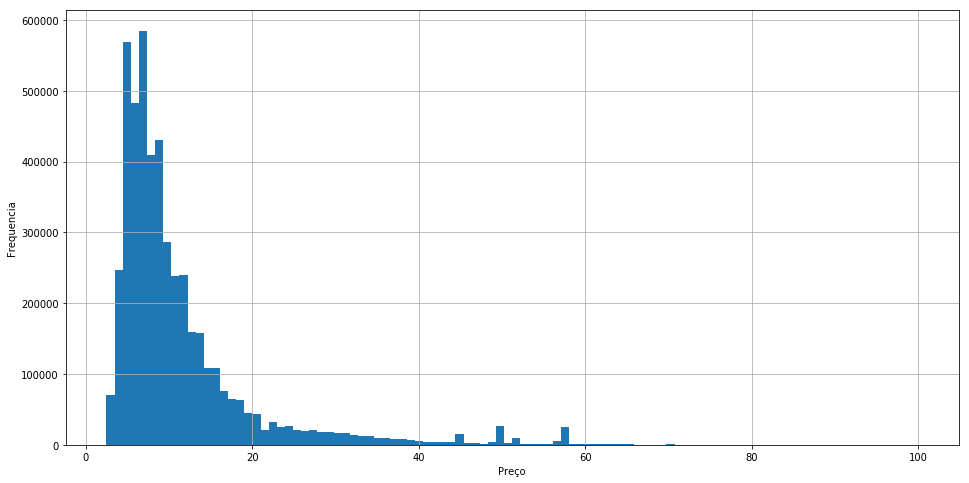

In [20]:
train[train.fare_amount<100].fare_amount.hist(bins=100,figsize = (16,8))
plt.xlabel('Preço')
plt.ylabel('Frequencia')

De qualquer forma existem alguns casos em que o valor utrapassa os $100 : 

In [21]:
train[train.fare_amount>100].shape

(1559, 8)

O gráfico a seguir mostras os casos para o preço acima de $100 :

Text(0, 0.5, 'Frequencia')

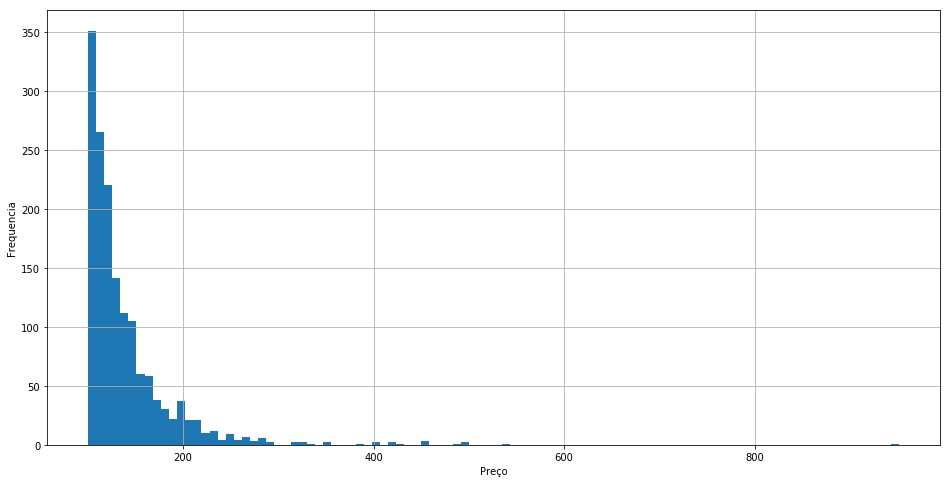

In [22]:
train[train.fare_amount>100].fare_amount.hist(bins=100,figsize=(16,8))
plt.xlabel('Preço')
plt.ylabel('Frequencia')

O gráfico a seguir mostra uma relação entre o número de passageiros e a frequencia de viagens :  

Text(0, 0.5, 'Frequencia')

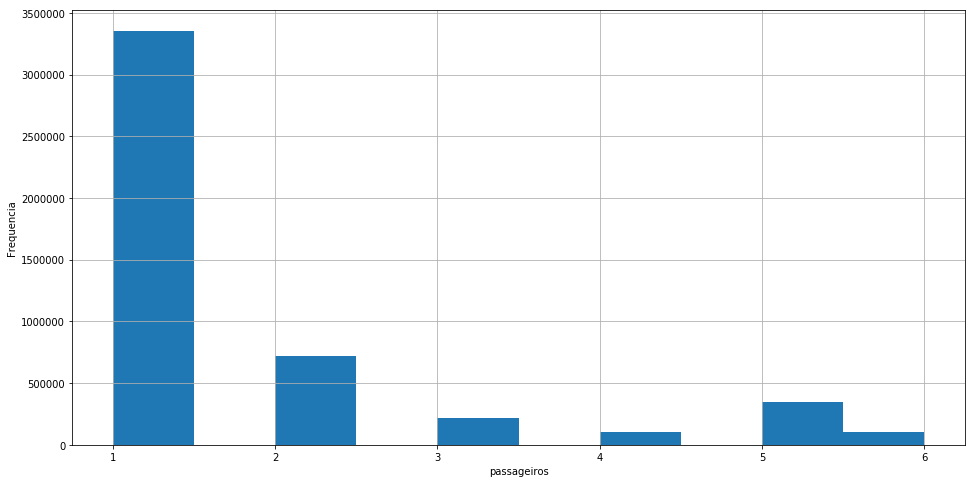

In [23]:
train[train.passenger_count <7].passenger_count.hist(bins=10,figsize=(16,8))
plt.xlabel('passageiros')
plt.ylabel('Frequencia')

Agora um gráfico box representa melhor a distribuição empirica dos dados :

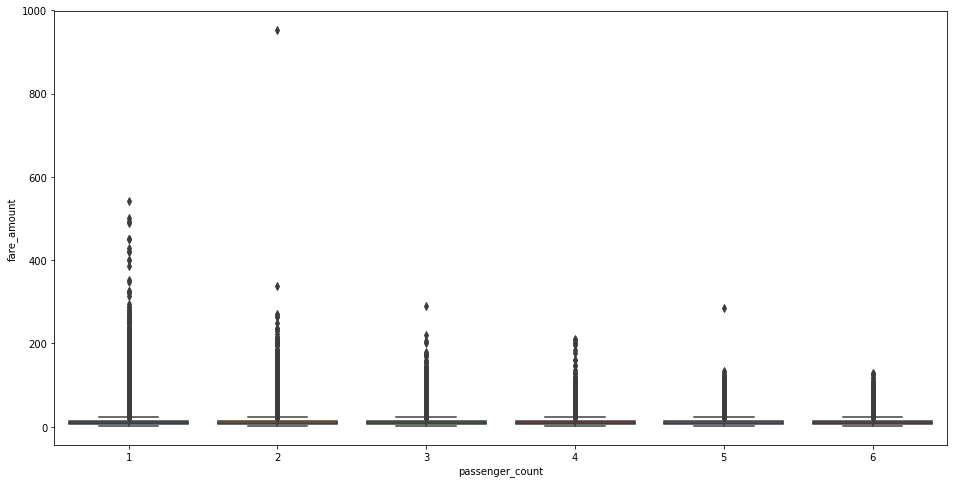

In [24]:
plt.figure(figsize = (16,8))
sns.boxplot(x = train[train.passenger_count<7].passenger_count,y=train.fare_amount)

O gráfico boxplot anterior representa bem que a relação do preço da corrida e a quantidade de passageiros não são importantes, já que o mesmo se aproximou de zero. Para confirmar essa afirmação é possível uilizar a correlação dessas duas variáveis : 

In [25]:
train[train.passenger_count <7][['fare_amount','passenger_count']].corr()

,fare_amount,passenger_count
fare_amount,1.000000,0.014059
passenger_count,0.014059,1.000000


Comprovando que essa é uma correlação fraca = 0,014. Provando que não existe relação entre o preço da corrida e o numero de passageiros. 



---


#Importando test

Importando test.csv para o data frame e mostrando o tamanho de test, junto com o formato dos dados. Obs.: O test não tem a coluna dos preço justamente por ser ela que precisa ser encontrada:

In [26]:
test = pd.read_csv('test.csv')
print('Shape de teste ', test.shape)
test.head()

Shape de teste  (9914, 7)


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


É preciso verificar se dentro de teste existe algum valor nulo : 

In [27]:
test.isnull().sum()

key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

Não existe valores nulos !

In [28]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


Distância de Mahanttan, a mesma é definida pela formula :

** |*x1-x2*| + |*y1-y2*|**

In [0]:
def prepar_time(df):
  df['pickup_datetime'] = df['pickup_datetime'].str.slice(0,16)
  df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True, format = "%Y-%m-%d %H:%M") 
  df['hour'] = df.pickup_datetime.dt.hour
  df['month'] = df.pickup_datetime.dt.month
  df['year'] = df.pickup_datetime.dt.year
  df['weekday'] = df.pickup_datetime.dt.weekday
  return df   

In [30]:
train = prepar_time(train)
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,month,year,weekday
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:00+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,6,2009,0
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:00+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,1,2010,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,8,2011,3
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:00+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,4,2012,5
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,3,2010,1


In [31]:
test = prepar_time(test)
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,month,year,weekday
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:00+00:00,-73.973320,40.763805,-73.981430,40.743835,1,13,1,2015,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:00+00:00,-73.986862,40.719383,-73.998886,40.739201,1,13,1,2015,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:00+00:00,-73.982524,40.751260,-73.979654,40.746139,1,11,10,2011,5
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:00+00:00,-73.981160,40.767807,-73.990448,40.751635,1,21,12,2012,5
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:00+00:00,-73.966046,40.789775,-73.988565,40.744427,1,21,12,2012,5


In [0]:
def distancia_mahanttan (lat1,lon1,lat2,lon2):
  return abs(lat1-lat2)+abs(lon1-lon2) 

In [33]:
train['distance'] = distancia_mahanttan(train.pickup_latitude,train.pickup_longitude,train.dropoff_latitude,train.dropoff_longitude)
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,month,year,weekday,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:00+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,6,2009,0,0.011742
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:00+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,1,2010,1,0.107481
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,8,2011,3,0.019212
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:00+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,4,2012,5,0.029386
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,3,2010,1,0.027194


In [34]:
test['distance'] = distancia_mahanttan(test.pickup_latitude,test.pickup_longitude,test.dropoff_latitude,test.dropoff_longitude)
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,month,year,weekday,distance
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:00+00:00,-73.973320,40.763805,-73.981430,40.743835,1,13,1,2015,1,0.028080
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:00+00:00,-73.986862,40.719383,-73.998886,40.739201,1,13,1,2015,1,0.031841
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:00+00:00,-73.982524,40.751260,-73.979654,40.746139,1,11,10,2011,5,0.007991
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:00+00:00,-73.981160,40.767807,-73.990448,40.751635,1,21,12,2012,5,0.025460
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:00+00:00,-73.966046,40.789775,-73.988565,40.744427,1,21,12,2012,5,0.067867


In [35]:
train[train['fare_amount']==0].shape

(0, 13)

In [36]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,month,year,weekday,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:00+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,6,2009,0,0.011742
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:00+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,1,2010,1,0.107481
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,8,2011,3,0.019212
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:00+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,4,2012,5,0.029386
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,3,2010,1,0.027194


In [37]:
#train['fare_amount','distance'].corr()
np.corrcoef(train['fare_amount'],train['distance'])

array([[1.        , 0.00814699],
       [0.00814699, 1.        ]])

In [38]:
y = train['fare_amount'].values
X = train[['hour','year','distance']].values
print(y)
print(X)

[ 4.5 16.9  5.7 ... 10.5 10.   4.9]
[[1.7000000e+01 2.0090000e+03 1.1742000e-02]
 [1.6000000e+01 2.0100000e+03 1.0748100e-01]
 [0.0000000e+00 2.0110000e+03 1.9212000e-02]
 ...
 [2.3000000e+01 2.0140000e+03 1.9536000e-02]
 [1.9000000e+01 2.0150000e+03 1.4755249e-02]
 [8.0000000e+00 2.0120000e+03 1.8010000e-02]]


In [39]:
train[train.passenger_count <7][['fare_amount','passenger_count']].corr()

,fare_amount,passenger_count
fare_amount,1.000000,0.014059
passenger_count,0.014059,1.000000


In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,random_state=42)

# Utilizando LinearRegression

In [0]:
reg_lin = LinearRegression()

In [0]:
reg_lin.fit(X_train,y_train)

In [0]:
y_predic_lin = reg_lin.predict(X_test)

In [0]:
score_lin = reg_lin.score(X_test,y_test)

In [0]:
print(str(score_lin*100) +'%')

# Utilizando SGB 

In [0]:
SGD_TAXI = linear_model.SGDRegressor()

In [42]:
SGD_TAXI.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [0]:
y_predic = SGD_TAXI.predict(X_test)

In [0]:
score_SGD = SGD_TAXI.score(X_test,y_test)

In [45]:
print(str(score_SGD*100)+'%')

-1.4941006758957803e+28%


# Usando XG Boost Model 

In [0]:
import xgboost as xgb 

In [0]:
params = {
   
    'max_depth': 7,
    'gamma' :0,
    'eta':.03, 
    'subsample': 1,
    'colsample_bytree': 0.9, 
    'objective':'reg:linear',
    'eval_metric':'rmse',
    'silent': 0
}

In [0]:
def XGBmodel(X_train,X_test,y_train,y_test,params):
    matrix_train = xgb.DMatrix(X_train,label=y_train)
    matrix_test = xgb.DMatrix(X_test,label=y_test)
    model=xgb.train(params=params,
                    dtrain=matrix_train,num_boost_round=5000, 
                    early_stopping_rounds=10,evals=[(matrix_test,'test')])
    return model

model = XGBmodel(X_train,X_test,y_train,y_test,params)

[04:54:09] WARNING: /workspace/src/learner.cc:685: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	test-rmse:14.0797
Will train until test-rmse hasn't improved in 10 rounds.
[1]	test-rmse:13.8441
[2]	test-rmse:13.6164
[3]	test-rmse:13.3996
[4]	test-rmse:13.0542
[5]	test-rmse:12.7225
[6]	test-rmse:12.4027
[7]	test-rmse:12.0913
[8]	test-rmse:11.791
[9]	test-rmse:11.5013
[10]	test-rmse:11.3335
[11]	test-rmse:11.0619
[12]	test-rmse:10.8
[13]	test-rmse:10.6511
[14]	test-rmse:10.4022
[15]	test-rmse:10.1624
[16]	test-rmse:9.9317
[17]	test-rmse:9.80486
[18]	test-rmse:9.58734
[19]	test-rmse:9.4711
[20]	test-rmse:9.26755
[21]	test-rmse:9.161
[22]	test-rmse:8.96824
[23]	test-rmse:8.87074
[24]	test-rmse:8.77806
[25]	test-rmse:8.60136
[26]	test-rmse:8.43057
[27]	test-rmse:8.34933
[28]	test-rmse:8.18875
[29]	test-rmse:8.03467
[30]	test-rmse:7.88758
[31]	test-rmse:7.81955
[32]	test-r

In [0]:
test = pd.read_csv('test.csv')
test = test.drop(['key','pickup_datetime'],axis =1 ).copy()

In [0]:

prediction = model.predict(xgb.DMatrix(test), ntree_limit = model.best_ntree_limit).tolist()